# Layer Vb mice

In [1]:
# Imports:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import math
import psycopg2
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook

from scipy import signal 

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *
from postgres_analysis_helpers.general import *
from postgres_analysis_helpers.get_data import *
from postgres_analysis_helpers.circstat_functions import *
from postgres_analysis_helpers.extra_analysis import *

# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

Loaded analysis helpers: General
Loaded postgres_analysis_helpers -> general
Loaded postgres_analysis_helpers -> get_data
Loaded postgres_analysis_helpers -> circstat_functions
Loaded postgres_analysis_helpers -> extra analysis


In [2]:
# Database connection check
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Woot! Database connection is established!')

Connecting to the PostgreSQL database...
Woot! Database connection is established!


# Load data

In [3]:
stimulus_stats = pd.DataFrame() # create empty dataframe or feed in a base dataframe from before! 
psql = psql_neuroballs(stimulus_stats) # initialize retrieval

dict_ = {'stimulus_tb': ''}
animals_ = ['78367','76344','79299','80572','80250','79815']
filter_ = "AND session_name NOT LIKE '%obj%' AND session_name NOT LIKE '%stab%' AND session_name NOT LIKE '%room%' AND session_name NOT LIKE '%bord%'"
stimulus_stats = psql.retrieve_data(dict_,animals_,filter_)

89 animals across 5 experimenters found.
Total # of sessions: 10197 (unique clusters: 16946)
3145 entries retrieved.


In [4]:
stimulus_stats.columns

Index(['cluster_no', 'n_drive_user', 'animal_id', 'session_ts', 'session_name',
       'tetrode_no', 'analysis_ts', 'filename', 'analysis_window',
       'salt_window', 'sample_rate', 'sample_rate_inp', 'ibi', 'stim_freq',
       'stim_length', 'counter_stimuli', 'excited', 'salt_p', 'salt_i',
       'ex_latency_mean', 'ex_latency_median', 'ex_latency_var',
       'ex_latency_reliabil', 'stats_p_inhib_10', 'stats_p_inhib_20',
       'stats_p_inhib_30', 'stats_p_inhib_40', 'inhibited', 'inhib_lowest_p',
       'inhib_lowest_p_interval', 'change_point_ms'],
      dtype='object')

In [5]:
# Set parameters:
# excitation:
salt_i_thresh = 0.09
salt_p_thresh = 0.05
min_number_sessions = 2 # min number of session for which criteria above have to be fullfilled
pearson_r_thresh = 0.99 # waveform similarity cutoff

# ISI contamination (%)
isi_contam_thresh = 1

# inhibition:
p_inhib_thresh = 0.001 # inhibition threshold
inhib_interval_ = 10 # Interval to filter for - to get rid of spurious results (blanking artefacts) 
# ISI contamination (%)
isi_contam_thresh = 1

In [6]:
labels_excited_ = []
labels_inhibited_ = []

for i in tqdm_notebook(range(len(stimulus_stats))):
   
    if (stimulus_stats.iloc[i].salt_i >= salt_i_thresh) and (stimulus_stats.iloc[i].salt_p < salt_p_thresh):
        labels_excited_.append('excited')
    else:
        labels_excited_.append('not_excited')
    ######################################################################
    if (stimulus_stats.iloc[i].inhib_lowest_p < p_inhib_thresh) and (stimulus_stats.iloc[i].inhib_lowest_p_interval > inhib_interval_) and \
                                (stimulus_stats.iloc[i].inhibited == True):
        labels_inhibited_.append('inhibited')
    else:
        labels_inhibited_.append('not_inhibited')
    ######################################################################
        
stimulus_stats['excited_'] = labels_excited_
stimulus_stats['inhibited_'] = labels_inhibited_

HBox(children=(IntProgress(value=0, max=3145), HTML(value='')))

In [7]:
excited_cells = stimulus_stats[stimulus_stats['excited_'] == 'excited'].reset_index(drop=True)
excited_cells.sort_values(by='salt_i',ascending=False,inplace=True)
excited_cells.reset_index(inplace=True,drop=True)

inhibited_cells = stimulus_stats[stimulus_stats['inhibited_'] == 'inhibited'].reset_index(drop=True)
inhibited_cells.sort_values(by='inhib_lowest_p',ascending=True,inplace=True)
inhibited_cells.reset_index(inplace=True,drop=True)

rest_cells = stimulus_stats[(stimulus_stats['inhibited_'] == 'not_inhibited') &\
                           (stimulus_stats['excited_'] == 'not_excited')].reset_index(drop=True)
rest_cells.reset_index(inplace=True,drop=True)

In [8]:
# Excited cells:
drop_subgroup_excited = ['animal_id','n_drive_user','session_ts','cluster_no','tetrode_no','excited_','filename']
drop_subgroup_inhibited = ['animal_id','n_drive_user','session_ts','cluster_no','tetrode_no','inhibited_','filename']
drop_subgroup_rest = ['animal_id','n_drive_user','session_ts','cluster_no','tetrode_no','filename']

no_sessions_excited_cells = excited_cells.groupby(drop_subgroup_excited).size().reset_index().copy()
excited_cells_sessions = excited_cells.drop_duplicates(drop_subgroup_excited).sort_values(by=drop_subgroup_excited).reset_index().copy()

# Quick sanity check (both have to be true)
if ((no_sessions_excited_cells.animal_id.values == excited_cells_sessions.animal_id.values).all() != True) or ((no_sessions_excited_cells.cluster_no.values == excited_cells_sessions.cluster_no.values).all() != True): 
    print('DATAFRAMES DO NOT MATCH!'); sys.exit()
excited_cells_sessions['no_sessions'] = no_sessions_excited_cells.iloc[:,-1].values

# Inhibited cells:
no_sessions_inhibited_cells = inhibited_cells.groupby(drop_subgroup_inhibited).size().reset_index().copy()
inhibited_cells_sessions = inhibited_cells.drop_duplicates(drop_subgroup_inhibited).sort_values(by=drop_subgroup_inhibited).reset_index().copy()

# Quick sanity check (both have to be true)
if ((no_sessions_inhibited_cells.animal_id.values == inhibited_cells_sessions.animal_id.values).all() != True) or ((no_sessions_inhibited_cells.cluster_no.values == inhibited_cells_sessions.cluster_no.values).all() != True): 
    print('DATAFRAMES DO NOT MATCH!'); sys.exit()
inhibited_cells_sessions['no_sessions'] = no_sessions_inhibited_cells.iloc[:,-1].values

# Rest of cells:
no_sessions_rest_cells = rest_cells.groupby(drop_subgroup_rest).size().reset_index().copy()
rest_cells_sessions = rest_cells.drop_duplicates(drop_subgroup_rest).sort_values(by=drop_subgroup_rest).reset_index().copy()

# Quick sanity check (both have to be true)
if ((no_sessions_rest_cells.animal_id.values == rest_cells_sessions.animal_id.values).all() != True) or ((no_sessions_rest_cells.cluster_no.values == rest_cells_sessions.cluster_no.values).all() != True): 
    print('DATAFRAMES DO NOT MATCH!'); sys.exit()
    
rest_cells_sessions['no_sessions'] = no_sessions_rest_cells.iloc[:,-1].values

In [9]:
labels_ = []
for i in range(len(excited_cells_sessions)):
    if excited_cells_sessions.iloc[i].no_sessions < min_number_sessions:
        labels_.append('not_excited')
    else:
        labels_.append('excited')
excited_cells_sessions['excited_'] = labels_ 

labels_ = []
for i in range(len(inhibited_cells_sessions)):
    if inhibited_cells_sessions.iloc[i].no_sessions < min_number_sessions:
        labels_.append('not_inhibited')
    else:
        labels_.append('inhibited')
inhibited_cells_sessions['inhibited_'] = labels_ 

In [10]:
# overwrite original dfs. 
excited_cells = excited_cells_sessions.copy()
inhibited_cells = inhibited_cells_sessions.copy()
rest_cells = rest_cells_sessions.copy()

In [11]:
psql = psql_neuroballs(excited_cells) # initialize retrieval
dict_ = {'waveforms_tb':'mean_wf'}
excited_cells = psql.retrieve_data(dict_)

psql = psql_neuroballs(inhibited_cells) # initialize retrieval
dict_ = {'waveforms_tb':'mean_wf'}
inhibited_cells = psql.retrieve_data(dict_)

Length of input dataframe: 19
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='waveforms_tb: ', max=19), HTML(value='')))

Success. NaNs: 2

Length of input dataframe: 22
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='waveforms_tb: ', max=22), HTML(value='')))

Success. NaNs: 0



In [12]:
excited_cells.rename(columns={'mean_wf':'mean_wf_laser','session_name':'session_name_laser'}, inplace=True) # rename the waveform column - "tag" with laser
inhibited_cells.rename(columns={'mean_wf':'mean_wf_laser','session_name':'session_name_laser'}, inplace=True) 
rest_cells.rename(columns={'session_name':'session_name_laser'}, inplace=True)

In [13]:
dict_ = {'waveforms_tb':'mean_wf','ISI_tb':'ISI_stats_contam_perc'}
filter_ = "NOT LIKE '%las%' AND session_name NOT LIKE '%obj%' AND session_name NOT LIKE '%stab%' AND session_name NOT LIKE '%room%' AND session_name NOT LIKE '%bord%'"

psql = psql_neuroballs(excited_cells) # initialize retrieval
excited_cells = psql.retrieve_data(user_sql_tables=dict_,user_sql_filter=filter_)

psql = psql_neuroballs(inhibited_cells) # initialize retrieval
inhibited_cells = psql.retrieve_data(user_sql_tables=dict_,user_sql_filter=filter_)

dict_ = {'ISI_tb':'ISI_stats_contam_perc'}
psql = psql_neuroballs(rest_cells) # initialize retrieval
rest_cells = psql.retrieve_data(user_sql_tables=dict_,user_sql_filter=filter_)

Length of input dataframe: 19
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='waveforms_tb: ', max=19), HTML(value='')))

Success. NaNs: 1


HBox(children=(IntProgress(value=0, description='ISI_tb: ', max=19), HTML(value='')))

Success. NaNs: 1

Length of input dataframe: 22
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='waveforms_tb: ', max=22), HTML(value='')))

Success. NaNs: 0


HBox(children=(IntProgress(value=0, description='ISI_tb: ', max=22), HTML(value='')))

Success. NaNs: 0

Length of input dataframe: 458
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ISI_tb: ', max=458), HTML(value='')))

Success. NaNs: 0



In [14]:
# get rid of duplicates
drop_subgroup = ['animal_id','n_drive_user','session_ts','cluster_no','tetrode_no','excited_','inhibited_','filename']
inhibited_cells = inhibited_cells.drop_duplicates(drop_subgroup).reset_index().copy()
excited_cells = excited_cells.drop_duplicates(drop_subgroup).reset_index().copy()
rest_cells = rest_cells.drop_duplicates(drop_subgroup).reset_index().copy()

### Drop nans (careful! these cells will not appear anymore!) 

In [15]:
excited_cells.dropna(subset=['mean_wf','mean_wf_laser','isi_stats_contam_perc'],inplace=True)
inhibited_cells.dropna(subset=['mean_wf','mean_wf_laser','isi_stats_contam_perc'],inplace=True)
rest_cells.dropna(subset=['isi_stats_contam_perc'],inplace=True) # for rest cells only get rid of isi contaminations

### Rest of the cells: get rid of ISI contaminated cells

In [16]:
inhibited_cells = inhibited_cells[inhibited_cells.isi_stats_contam_perc < isi_contam_thresh].copy()
excited_cells = excited_cells[excited_cells.isi_stats_contam_perc < isi_contam_thresh].copy()
rest_cells = rest_cells[rest_cells.isi_stats_contam_perc < isi_contam_thresh].copy()

### Calculate pearson's R between waveforms 

In [17]:
#sns.set(font_scale=2.2,style='white')
#
#wf_r,wf_p = corr_wf_base_laser(excited_cells.sort_values(by='salt_i',ascending=False)[:5], 'mean_wf', 'mean_wf_laser', plotting=True)
#labels_exc_ = []
#labels_inhib_ = []
#for i in range(len(excited_cells)):
#    if wf_r[i] < pearson_r_thresh:   
#        labels_exc_.append('not_excited')
#        labels_inhib_.append('not_inhibited')
#    else:
#        labels_exc_.append(excited_cells.iloc[i].excited_)
#        labels_inhib_.append(excited_cells.iloc[i].inhibited_)
#excited_cells['excited_'] = labels_exc_   
#excited_cells['inhibited_'] = labels_inhib_ 

In [18]:
wf_r,wf_p = corr_wf_base_laser(excited_cells, 'mean_wf', 'mean_wf_laser', plotting=False)
labels_exc_ = []
labels_inhib_ = []
for i in range(len(excited_cells)):
    if wf_r[i] < pearson_r_thresh:   
        labels_exc_.append('not_excited')
        labels_inhib_.append('not_inhibited')
    else:
        labels_exc_.append(excited_cells.iloc[i].excited_)
        labels_inhib_.append(excited_cells.iloc[i].inhibited_)
excited_cells['excited_'] = labels_exc_   
excited_cells['inhibited_'] = labels_inhib_   
        
wf_r,wf_p = corr_wf_base_laser(inhibited_cells, 'mean_wf', 'mean_wf_laser', plotting=False)
labels_exc_ = []
labels_inhib_ = []
for i in range(len(inhibited_cells)):
    if wf_r[i] < pearson_r_thresh:   
        labels_exc_.append('not_excited')
        labels_inhib_.append('not_inhibited')
    else:
        labels_exc_.append(inhibited_cells.iloc[i].excited_)
        labels_inhib_.append(inhibited_cells.iloc[i].inhibited_)

inhibited_cells['excited_'] = labels_exc_   
inhibited_cells['inhibited_'] = labels_inhib_   

In [19]:
# Sort again - why not ... 
excited_cells.sort_values(by='salt_i',ascending=False,inplace=True)
inhibited_cells.sort_values(by='inhib_lowest_p',ascending=True,inplace=True)

In [20]:
len(excited_cells)

14

### Snippets of every dataframe

In [21]:
columns_to_keep = ['animal_id','n_drive_user','filename','session_ts','session_name','session_name_laser','tetrode_no','cluster_no','excited_','inhibited_']

In [22]:
# double labeled cells

In [23]:
excited_cells[(excited_cells.excited_ == 'excited') & (excited_cells.inhibited_ == 'inhibited')][columns_to_keep]

,animal_id,n_drive_user,filename,session_ts,session_name,session_name_laser,tetrode_no,cluster_no,excited_,inhibited_


In [24]:
inhibited_cells[(inhibited_cells.excited_ == 'excited') & (inhibited_cells.inhibited_ == 'inhibited')][columns_to_keep]

,animal_id,n_drive_user,filename,session_ts,session_name,session_name_laser,tetrode_no,cluster_no,excited_,inhibited_


### Combine the dataframes into one

In [25]:
excited_cells_ = excited_cells[excited_cells.excited_ == 'excited'][columns_to_keep].copy()
excited_cells_rest = excited_cells[excited_cells.excited_ == 'not_excited'][columns_to_keep].copy()

inhibited_cells_ = inhibited_cells[inhibited_cells.inhibited_ == 'inhibited'][columns_to_keep].copy()
inhibited_cells_rest = inhibited_cells[inhibited_cells.inhibited_ == 'not_inhibited'][columns_to_keep].copy()

columns_for_drop = ['animal_id','n_drive_user','filename','session_ts','tetrode_no','cluster_no']
excited_cells_.drop_duplicates(subset=columns_for_drop,inplace=True)
inhibited_cells_.drop_duplicates(subset=columns_for_drop,inplace=True)

In [26]:
excited_inhibited = pd.concat([excited_cells_,inhibited_cells_],ignore_index=True)

In [27]:
# First look at the excited and inhibited cells - find double labels
labels_ = []
for i in range(len(excited_inhibited)):
    if excited_inhibited.duplicated(subset=columns_for_drop,keep=False).iloc[i] == True:
        labels_.append('both')
    elif excited_inhibited.iloc[i].excited_ == 'excited':
        labels_.append('excited')
    elif excited_inhibited.iloc[i].inhibited_ == 'inhibited':
        labels_.append('inhibited')
    else:
        print('wtf dude!')
        
excited_inhibited['label'] = labels_

In [28]:
labels_ = []
for i in range(len(excited_inhibited)):
    if excited_inhibited.iloc[i].excited_ == 'excited':
        labels_.append('excited')
    elif excited_inhibited.iloc[i].inhibited_ == 'inhibited':
        labels_.append('inhibited')
    else:
        print('wtf dude!')
        
excited_inhibited['label'] = labels_

In [29]:
rest_cells = rest_cells[columns_to_keep].copy()
all_data_rest = pd.concat([rest_cells,excited_cells_rest,inhibited_cells_rest],ignore_index=True)

In [30]:
labels_ = []
for i in range(len(all_data_rest)):
    if all_data_rest.iloc[i].excited_ == 'not_excited':
        labels_.append('rest')
    elif all_data_rest.iloc[i].inhibited_ == 'not_inhibited':
        labels_.append('rest')
    else:
        print('wtf dude!')
        
all_data_rest['label'] = labels_

In [31]:
# Concatenate all 
all_ = pd.concat([excited_inhibited,all_data_rest])

In [32]:
all_.sort_values(by='label',ascending=True,inplace=True)
# THIS SORTING STEP IS IMPORTANT: this way, "both" comes first and is maintained when duplicates are dropped
columns_for_drop = ['animal_id','n_drive_user','filename','session_ts','tetrode_no','cluster_no']
all_ = all_.drop_duplicates(subset=columns_for_drop).copy()

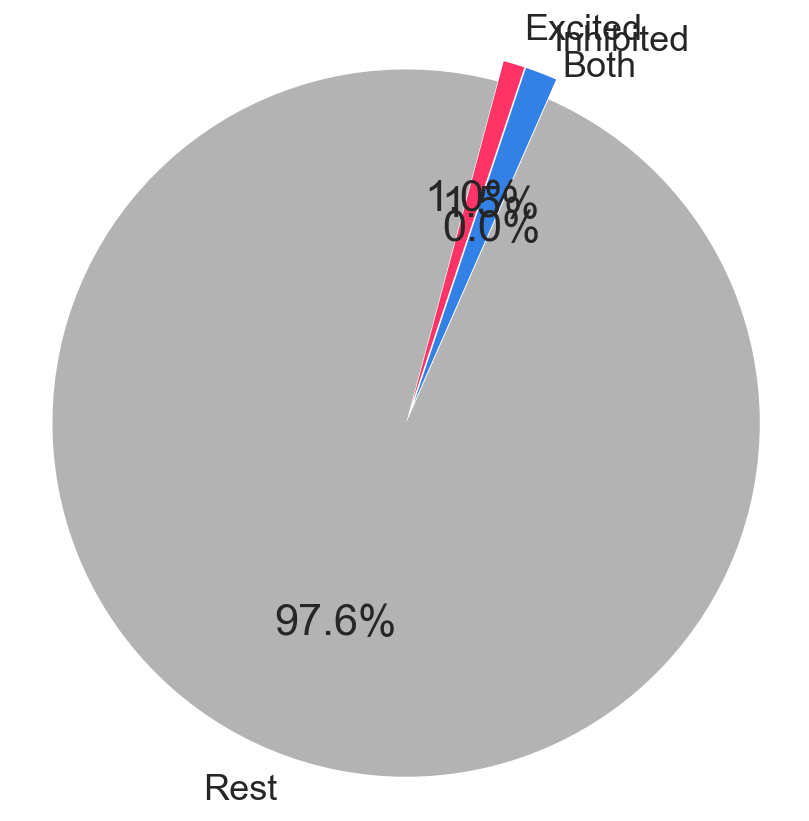

In [33]:
sns.set(font_scale=1.8)
labels = 'Excited', 'Inhibited', 'Both', 'Rest'
sizes = [len(all_[all_.label == 'excited']),\
          len(all_[all_.label == 'inhibited']),\
              len(all_[all_.label == 'both']),\
                len(all_[all_.label == 'rest'])]
explode = (.06,.06,0,0)  

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=75,counterclock=False,colors=[[1,.2,.4],[.2,.5,.9],[.9,.9,.9],[.7,.7,.7]])
ax1.axis('equal') 
plt.show()

### Drop nans (careful! these cells will not appear anymore!) 

In [34]:
psql = psql_neuroballs(vb_all[vb_all.label2 == 'excited'])
dict_ = {'stimulus_tb':'','stimulus_mat_tb':''}
data_to_draw = psql.retrieve_data(dict_)
create_spike_plots_stimulus(data_to_draw.sort_values(by='inhib_lowest_p',ascending=True),5,0,True)

NameError: name 'vb_all' is not defined

In [ ]:
print('Summary')
print('Excited       {}'.format(len(all_[all_.label == 'excited'])))
print('Inhibited     {}'.format(len(all_[all_.label == 'inhibited'])))
print('Both          {}'.format(len(all_[all_.label == 'both'])))
print('Rest          {}'.format(len(all_[all_.label == 'rest'])))
print('Sum           {}'.format(len(all_[all_.label == 'rest'])+len(all_[all_.label == 'excited'])+len(all_[all_.label == 'inhibited'])+len(all_[all_.label == 'both'])))

### Rename and clean

In [ ]:
all_.rename(columns={'session_name':'session_name_base','session_name_laser':'session_name'}, inplace=True)

### SAVE!

In [ ]:
all_.to_pickle('dataframe_export/layerVb.pkl')

In [ ]:
vb_all=all_

### Need to rename columns so retrieval happens on the "base" session, not "laser" session:

In [ ]:
vb_all.rename(columns={'session_name':'session_name_laser','session_name_base':'session_name'}, inplace=True)

### Define cutoffs

In [ ]:
# taking the 95th percentiles for now 
grid_cutoff =  0.2980
mvl_cutoff = 0.1713
speed_cutoff = 0.1907
spatial_info_cutoff = 0.8204
border_cutoff = 0.5007
rate_cutoff = 0.2 

# Retrieve data (add whatever you want)

In [ ]:
psql = psql_neuroballs(vb_all) # initialize retrieval
dict_ = {'spiketimes_tracking_tb': ('mean_freq',),\
         'phase_tuning_tb': ('bins_angle_center_phase', 'hist_angle_smooth_phase', 'phase_stats_MVL', 'phase_stats_mean', 'phase_stats_var', 'rayleigh_p', 'spike_trig_lfp'),\
         'hd_tuning_tb': ('bins_angle_center', 'hist_angle_smooth', 'tc_stats_MVL', 'tc_stats_mean', 'tc_stats_var'), \
         'waveforms_tb': ('mean_wf', 'std_wf', 'maxima_wf'), \
         'BNT_tb_screen': ('InformationContent_bnt', 'tc_stats_hd_peakrate_bnt', 'tc_stats_mean_direction_bnt', 'peak_rate_bnt', 'gridstats_spacing_bnt', 'borderscore_bnt', 'angular_stability_bnt','InformationRate_bnt', 'speedscore_bnt', 'tc_stats_peakdirection_bnt', 'tc_stats_mvl_bnt', 'coherence_bnt', 'grid_score_bnt', 'sparsity_bnt', 'theta_strength_bnt', 'selectivity_bnt', 'mean_rate_bnt', 'theta_mean_phase_bnt', 'hist_angle_smooth_bnt', 'bins_angle_center_bnt','calbindin_bnt','calbindin_dist_bnt'),\
         'waveforms_stats_tb': ('artefact', 'idx_max_wf', 'idx_min_wf', 'swidth'),\
         'st_autocorr_tb':('burst_idx2',),\
         'ISI_tb':('isi_stats_percent_bursts'),\
         'stimulus_tb':'',\
         'stimulus_mat_tb':''}
         
filter_ = "NOT LIKE '%obj%' AND session_name NOT LIKE '%stab%' AND session_name NOT LIKE '%rest%' AND session_name NOT LIKE '%room%' AND session_name NOT LIKE '%bord%'"

vb_all = psql.retrieve_data(user_sql_tables=dict_,user_sql_filter=filter_)


vb_all = vb_all.dropna(subset=['calbindin_bnt'])#This will drop cells that have important data missing (quality control)
drop_subgroup= ['session_ts','session_name','cluster_no','tetrode_no']
vb_all = vb_all.drop_duplicates(subset=drop_subgroup, keep='first', inplace=False)


In [ ]:
labels2_ = []
for i in range(len(vb_all)):
    if vb_all.iloc[i].label == 'excited':
        labels2_.append('tagged')
    elif vb_all.iloc[i].label != 'excited':
        labels2_.append('rest')
    else:
        print('wtf dude!')
        
vb_all['label2'] = labels2_



In [ ]:
psql = psql_neuroballs(vb_all[vb_all.label2 == 'excited'])
dict_ = {'stimulus_tb':'','stimulus_mat_tb':''}
data_to_draw = psql.retrieve_data(dict_)
create_spike_plots_stimulus(data_to_draw,5,0,True)

# visualize some data
Executing this notebook will reproduce the images in figure 3 of our paper and run the corresponding statistical tests described in the text.  

In [ ]:
vb_all.columns

In [ ]:
vb_all.label.unique()

## Get total number of tagged cells
This will retrieve all the cells that were tagged in the dataset (see text for criteria)

In [ ]:
cells = vb_all[(vb_all.label == 'excited')].copy()
inhib_cells = vb_all[(vb_all.label == 'inhibited')].copy()
label = 'Tagged Vb\nn={}'.format(len(cells))

In [ ]:
print('There are {} in this filtered dataframe. Label: {}'.format(len(vb_all),label))

## Draw stacked bar chart
The following sections draw the stacked bar charts used in Figure 3, first for the tagged cells and then for the remaining cells. The bar charts have a dark color for cells that fall into one category ("pure") and a lighter color for cells that fall into multiple categories ("mix"). The percentages above the bars give the total number. Note that all "mix" cells are counted in at least 2 categories and therefore the percentages will not sum to 100%. We prefered this represenation of the data to a pie chart (or similar) with different slices for all possible conjunctions (grid x HD, speed X border etc.) because the number of possible combinations is large and makes for a complicated figure.

In [ ]:
gridc = cells[cells.grid_score_bnt > grid_cutoff]
hdc = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt>0.6)]
speedc = cells[cells.speedscore_bnt > speed_cutoff]
borderc = cells[cells.borderscore_bnt > border_cutoff]


unclas = cells[(~cells.index.isin(gridc.index)) &\
               (~cells.index.isin(hdc.index))  &\
               (~cells.index.isin(speedc.index))  &\
               (~cells.index.isin(borderc.index))]

In [ ]:
# find all the class labels for "pure cells" by
# finding non-overlap within indices of other cell classes

pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [ ]:
all_len = len(cells)
# Grid
grid_len = len(gridc)
frac_grid = grid_len/all_len
pure_grid_len = len(pure_gridc)
mix_grid_len = grid_len-pure_grid_len

# HD
hd_len = len(hdc)
frac_hd = hd_len/all_len
pure_hd_len = len(pure_hdc)
mix_hd_len = hd_len-pure_hd_len

# Speed
speed_len = len(speedc)
frac_speed = speed_len/all_len
pure_speed_len = len(pure_speedc)
mix_speed_len = speed_len-pure_speed_len

# Border
border_len = len(borderc)
frac_border = border_len/all_len
pure_border_len = len(pure_borderc)
mix_border_len = border_len-pure_border_len

# Rest
#unstable_HD = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
unclas_len = len(unclas)
frac_unclas = unclas_len/all_len


In [ ]:
# grid, hd, speed, border, unclassified
from palettable.cartocolors.sequential import DarkMint_4,Peach_6,RedOr_6,Teal_6
#colors = RedOr_6.get_mpl_colormap()

seq_col_brew = sns.color_palette(sns.light_palette("cyan",5))
sns.set_palette(seq_col_brew)
#sns.set(font_scale=1.4,style='white')
plt.figure(figsize=(5,7))


N = 5
pure = (pure_grid_len/all_len, pure_hd_len/all_len, pure_speed_len/all_len, pure_border_len/all_len, unclas_len/all_len)
mix = (mix_grid_len/all_len, mix_hd_len/all_len, mix_speed_len/all_len, mix_border_len/all_len,0)

rest = ((all_len-(pure_grid_len+mix_grid_len))/all_len,\
        (all_len-(pure_hd_len+mix_hd_len))/all_len,\
        (all_len-(pure_speed_len+mix_speed_len))/all_len,\
        (all_len-(pure_border_len+mix_border_len))/all_len,\
        (all_len-unclas_len)/all_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=seq_col_brew[4])
p2 = plt.bar(ind, mix, width, color=seq_col_brew[0], bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [frac_grid,frac_hd,frac_speed,frac_border,frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig(r'N:\davidcr\stellate paper images\python output\tagged_stacked_bar.svg', format='svg', dpi=1000)
plt.show()
print(pure)

## Now make the same stacked bar but for all other cells

In [ ]:
non_tagged_cells = vb_all[(vb_all.label != 'excited')].copy()# retrieves all cells that were not tagged

label = 'untagged \nn={}'.format(len(non_tagged_cells))#and labels them

In [ ]:
print('There are {} in this filtered dataframe. Label: {}'.format(len(non_tagged_cells),label))

In [ ]:
gridc = non_tagged_cells[non_tagged_cells.grid_score_bnt > grid_cutoff]
hdc = non_tagged_cells[(non_tagged_cells.tc_stats_mvl_bnt > mvl_cutoff)&(non_tagged_cells.angular_stability_bnt>0.6)]
speedc = non_tagged_cells[non_tagged_cells.speedscore_bnt > speed_cutoff]
borderc = non_tagged_cells[non_tagged_cells.borderscore_bnt > border_cutoff]


unclas = non_tagged_cells[(~non_tagged_cells.index.isin(gridc.index)) &\
               (~non_tagged_cells.index.isin(hdc.index))  &\
               (~non_tagged_cells.index.isin(speedc.index))  &\
               (~non_tagged_cells.index.isin(borderc.index))]

In [ ]:
pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [ ]:
all_len = len(non_tagged_cells)
# Grid
grid_len = len(gridc)
frac_grid = grid_len/all_len
pure_grid_len = len(pure_gridc)
mix_grid_len = grid_len-pure_grid_len

# HD
hd_len = len(hdc)
frac_hd = hd_len/all_len
pure_hd_len = len(pure_hdc)
mix_hd_len = hd_len-pure_hd_len

# Speed
speed_len = len(speedc)
frac_speed = speed_len/all_len
pure_speed_len = len(pure_speedc)
mix_speed_len = speed_len-pure_speed_len

# Border
border_len = len(borderc)
frac_border = border_len/all_len
pure_border_len = len(pure_borderc)
mix_border_len = border_len-pure_border_len

# Rest
#unstable_HD = non_tagged_cells[(non_tagged_cells.tc_stats_mvl_bnt > mvl_cutoff)&(non_tagged_cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
unclas_len = len(unclas)
frac_unclas = unclas_len/all_len

In [ ]:
# grid, hd, speed, border, unclassified
from palettable.cartocolors.sequential import DarkMint_4,Peach_6,RedOr_6,Teal_6
#colors = RedOr_6.get_mpl_colormap()
colors = cm.Greys

sns.set(font_scale=1.4,style='white')
plt.figure(figsize=(5,7))


N = 5
pure = (pure_grid_len/all_len, pure_hd_len/all_len, pure_speed_len/all_len, pure_border_len/all_len, unclas_len/all_len)
mix = (mix_grid_len/all_len, mix_hd_len/all_len, mix_speed_len/all_len, mix_border_len/all_len,0)

rest = ((all_len-(pure_grid_len+mix_grid_len))/all_len,\
        (all_len-(pure_hd_len+mix_hd_len))/all_len,\
        (all_len-(pure_speed_len+mix_speed_len))/all_len,\
        (all_len-(pure_border_len+mix_border_len))/all_len,\
        (all_len-unclas_len)/all_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=colors(0.9))
p2 = plt.bar(ind, mix, width, color=colors(0.6), bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [frac_grid,frac_hd,frac_speed,frac_border,frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig(r'N:\davidcr\stellate paper images\python output\untagged_stacked_bar.svg', format='svg', dpi=1000)
plt.show()
print(pure)

## Compare scores between tagged and untagged populations
The following section will compare the functional properties between tagged and untagged cells.The code is essentially repeated for each variable. The only change is what is being ploted/compared. 


In [ ]:
figure = plt.figure(facecolor='w')

sns.set(font_scale=1.)
sns.set_style('white')
 
    

figure.set_size_inches(11.7, 8.27)

sns.set_style("white")

vb_all["null"] = ""

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
#sns.palplot(sns.color_palette())

ax = sns.violinplot(x = vb_all["null"],y=vb_all.grid_score_bnt.astype(float) , hue = vb_all.label2,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax = sns.stripplot(x = vb_all["null"],y=vb_all.grid_score_bnt.astype(float) , hue = vb_all.label2,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3)
ax.set(xlabel='', ylabel='Grid Score')
#plt.savefig(r'N:\davidcr\stellate paper images\python output\grid_score_violin.svg', format='svg', dpi=1000)


figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
ax2 = sns.violinplot(x = vb_all["null"],y=vb_all.borderscore_bnt.astype(float) , hue = vb_all.label2,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)

ax2 = sns.stripplot(x = vb_all["null"],y=vb_all.borderscore_bnt.astype(float) , hue = vb_all.label2,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3)
ax2.set(xlabel='', ylabel='Border Score')
#plt.savefig(r'N:\davidcr\stellate paper images\python output\border_score_violin.svg', format='svg', dpi=1000)


figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
ax2 = sns.violinplot(x = vb_all["null"],y=vb_all.tc_stats_mvl_bnt.astype(float) , hue = vb_all.label2,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax2 = sns.stripplot(x = vb_all["null"],y=vb_all.tc_stats_mvl_bnt.astype(float) , hue = vb_all.label2,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3 )
ax2.set(xlabel='', ylabel='HD Score (MVL)')
#plt.savefig(r'N:\davidcr\stellate paper images\python output\HD_score_violin.svg', format='svg', dpi=1000)


figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
ax2 = sns.violinplot(x = vb_all["null"],y=vb_all.speedscore_bnt.astype(float) , hue = vb_all.label2,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax2 = sns.stripplot(x = vb_all["null"],y=vb_all.speedscore_bnt.astype(float) , hue = vb_all.label2,jitter = True, dodge = True, size=10, linewidth=1, alpha = 0.3)
ax2.set(xlabel='', ylabel='Speed Score')
#plt.savefig(r'N:\davidcr\stellate paper images\python output\speed_score_violin.svg', format='svg', dpi=1000)

